In [1]:
# Importar bibliotecas necesarias
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, count, isnan, when, trim, to_timestamp, datediff, current_date, unix_timestamp,col, udf, when
from pyspark.sql.types import StringType, IntegerType, FloatType, TimestampType
from pyspark.sql.window import Window

1. Crear y inicializar SPARK

In [2]:
# Inicializar SparkSession
spark = SparkSession.builder \
    .appName("Marketin-predictivo") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

2. Leer los datasets

In [137]:
# Caminos para los archivos
path_clientes = "/home/jovyan/Marketing-Predictivo/CSV/OLIST/olist_customers_dataset.csv"
path_geolocation = "/home/jovyan/Marketing-Predictivo/CSV/OLIST/olist_geolocation_dataset.csv"
path_productos = "/home/jovyan/Marketing-Predictivo/CSV/OLIST/olist_products_dataset.csv"
path_product_translator = "/home/jovyan/Marketing-Predictivo/CSV/OLIST/product_category_name_translation.csv"
path_ordens = "/home/jovyan/Marketing-Predictivo/CSV/OLIST/olist_orders_dataset.csv"
path_ordens_itens = "/home/jovyan/Marketing-Predictivo/CSV/OLIST/olist_order_items_dataset.csv"
path_ordens_payments = "/home/jovyan/Marketing-Predictivo/CSV/OLIST/olist_order_payments_dataset.csv"
path_ordens_reviews= "/home/jovyan/Marketing-Predictivo/CSV/OLIST/olist_order_reviews_dataset.csv"


In [138]:
df_clientes = spark.read.csv(path_clientes, header=True, inferSchema=True, sep=',')
df_clientes.printSchema()
df_clientes.show(5, truncate=False)

root
 |-- customer_id: string (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- customer_zip_code_prefix: integer (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = true)

+--------------------------------+--------------------------------+------------------------+---------------------+--------------+
|customer_id                     |customer_unique_id              |customer_zip_code_prefix|customer_city        |customer_state|
+--------------------------------+--------------------------------+------------------------+---------------------+--------------+
|06b8999e2fba1a1fbc88172c00ba8bc7|861eff4711a542e4b93843c6dd7febb0|14409                   |franca               |SP            |
|18955e83d337fd6b2def6b18a428ac77|290c77bc529b7ac935b93aa66c333dc3|9790                    |sao bernardo do campo|SP            |
|4e7b3e00288586ebd08712fdd0374a03|060e732b5b29e8181a18229c7b0b2b5e|1151                    |sao paulo  

In [139]:
df_productos = spark.read.csv(path_productos, header=True, inferSchema=True, sep=',', multiLine=True, escape='"')
df_productos.printSchema()
df_productos.show(10, truncate=True)

root
 |-- product_id: string (nullable = true)
 |-- product_category_name: string (nullable = true)
 |-- product_name_lenght: integer (nullable = true)
 |-- product_description_lenght: integer (nullable = true)
 |-- product_photos_qty: integer (nullable = true)
 |-- product_weight_g: integer (nullable = true)
 |-- product_length_cm: integer (nullable = true)
 |-- product_height_cm: integer (nullable = true)
 |-- product_width_cm: integer (nullable = true)

+--------------------+---------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+
|          product_id|product_category_name|product_name_lenght|product_description_lenght|product_photos_qty|product_weight_g|product_length_cm|product_height_cm|product_width_cm|
+--------------------+---------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+--------------

In [140]:
df_productos_traducidos = spark.read.csv(path_product_translator, header=True, inferSchema=True, sep=',', multiLine=True, escape='"')
df_productos_traducidos.printSchema()
df_productos_traducidos.show(10, truncate=True)

root
 |-- product_category_name: string (nullable = true)
 |-- product_category_name_english: string (nullable = true)

+---------------------+-----------------------------+
|product_category_name|product_category_name_english|
+---------------------+-----------------------------+
|         beleza_saude|                health_beauty|
| informatica_acess...|         computers_accesso...|
|           automotivo|                         auto|
|      cama_mesa_banho|               bed_bath_table|
|     moveis_decoracao|              furniture_decor|
|        esporte_lazer|               sports_leisure|
|           perfumaria|                    perfumery|
| utilidades_domest...|                   housewares|
|            telefonia|                    telephony|
|   relogios_presentes|                watches_gifts|
+---------------------+-----------------------------+
only showing top 10 rows



In [141]:
df_ordens = spark.read.csv(path_ordens, header=True, inferSchema=True, sep=',')
df_ordens.printSchema()
df_ordens.show(5, truncate=False)

root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: string (nullable = true)
 |-- order_approved_at: string (nullable = true)
 |-- order_delivered_carrier_date: string (nullable = true)
 |-- order_delivered_customer_date: string (nullable = true)
 |-- order_estimated_delivery_date: string (nullable = true)

+--------------------------------+--------------------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+
|order_id                        |customer_id                     |order_status|order_purchase_timestamp|order_approved_at  |order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|
+--------------------------------+--------------------------------+------------+------------------------+-------------------+-------------------------

In [142]:
df_ordens_payments = spark.read.csv(path_ordens_payments, header=True, inferSchema=True, sep=',')
df_ordens_payments.printSchema()
df_ordens_payments.show(5, truncate=False)

root
 |-- order_id: string (nullable = true)
 |-- payment_sequential: integer (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- payment_installments: integer (nullable = true)
 |-- payment_value: double (nullable = true)

+--------------------------------+------------------+------------+--------------------+-------------+
|order_id                        |payment_sequential|payment_type|payment_installments|payment_value|
+--------------------------------+------------------+------------+--------------------+-------------+
|b81ef226f3fe1789b1e8b2acac839d17|1                 |credit_card |8                   |99.33        |
|a9810da82917af2d9aefd1278f1dcfa0|1                 |credit_card |1                   |24.39        |
|25e8ea4e93396b6fa0d3dd708e76c1bd|1                 |credit_card |1                   |65.71        |
|ba78997921bbcdc1373bb41e913ab953|1                 |credit_card |8                   |107.78       |
|42fdf880ba16b47b59251dd489d4441a|1            

In [143]:
df_ordens_itens = spark.read.csv(path_ordens_itens, header=True, inferSchema=True, sep=',')
df_ordens.printSchema()
df_ordens.show(5, truncate=False)

root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: string (nullable = true)
 |-- order_approved_at: string (nullable = true)
 |-- order_delivered_carrier_date: string (nullable = true)
 |-- order_delivered_customer_date: string (nullable = true)
 |-- order_estimated_delivery_date: string (nullable = true)

+--------------------------------+--------------------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+
|order_id                        |customer_id                     |order_status|order_purchase_timestamp|order_approved_at  |order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|
+--------------------------------+--------------------------------+------------+------------------------+-------------------+-------------------------

In [144]:
#no esta funcionando.

df_ordens_review = spark.read.csv(path_ordens_reviews, header=True, inferSchema=True, sep=',')
df_ordens_review.printSchema()
df_ordens_review.show(5, truncate=False)

Py4JJavaError: An error occurred while calling o2375.csv.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 282.0 failed 1 times, most recent failure: Lost task 1.0 in stage 282.0 (TID 432) (3f5bc3857611 executor driver): java.lang.NumberFormatException: For input string: "8278360118"
	at java.base/java.lang.NumberFormatException.forInputString(NumberFormatException.java:67)
	at java.base/java.lang.Integer.parseInt(Integer.java:668)
	at java.base/java.lang.Integer.parseInt(Integer.java:786)
	at org.apache.commons.lang3.time.FastDateParser$NumberStrategy.parse(FastDateParser.java:836)
	at org.apache.commons.lang3.time.FastDateParser.parse(FastDateParser.java:431)
	at org.apache.commons.lang3.time.FastDateFormat.parse(FastDateFormat.java:567)
	at org.apache.spark.sql.catalyst.util.LegacyFastTimestampFormatter.parseOptional(TimestampFormatter.scala:415)
	at org.apache.spark.sql.catalyst.csv.CSVInferSchema.tryParseTimestamp(CSVInferSchema.scala:214)
	at org.apache.spark.sql.catalyst.csv.CSVInferSchema.tryParseTimestampNTZ(CSVInferSchema.scala:208)
	at org.apache.spark.sql.catalyst.csv.CSVInferSchema.tryParseDouble(CSVInferSchema.scala:189)
	at org.apache.spark.sql.catalyst.csv.CSVInferSchema.$anonfun$tryParseDecimal$2(CSVInferSchema.scala:180)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.catalyst.csv.CSVInferSchema.tryParseDecimal(CSVInferSchema.scala:180)
	at org.apache.spark.sql.catalyst.csv.CSVInferSchema.tryParseLong(CSVInferSchema.scala:161)
	at org.apache.spark.sql.catalyst.csv.CSVInferSchema.tryParseInteger(CSVInferSchema.scala:153)
	at org.apache.spark.sql.catalyst.csv.CSVInferSchema.inferField(CSVInferSchema.scala:128)
	at org.apache.spark.sql.catalyst.csv.CSVInferSchema.inferRowType(CSVInferSchema.scala:107)
	at org.apache.spark.sql.catalyst.csv.CSVInferSchema.$anonfun$infer$2(CSVInferSchema.scala:81)
	at scala.collection.TraversableOnce$folder$1.apply(TraversableOnce.scala:196)
	at scala.collection.TraversableOnce$folder$1.apply(TraversableOnce.scala:194)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$2(RDD.scala:1223)
	at org.apache.spark.SparkContext.$anonfun$runJob$6(SparkContext.scala:2492)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2493)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$1(RDD.scala:1225)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.aggregate(RDD.scala:1218)
	at org.apache.spark.sql.catalyst.csv.CSVInferSchema.infer(CSVInferSchema.scala:81)
	at org.apache.spark.sql.execution.datasources.csv.TextInputCSVDataSource$.$anonfun$inferFromDataset$4(CSVDataSource.scala:137)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.datasources.csv.TextInputCSVDataSource$.inferFromDataset(CSVDataSource.scala:137)
	at org.apache.spark.sql.execution.datasources.csv.TextInputCSVDataSource$.infer(CSVDataSource.scala:112)
	at org.apache.spark.sql.execution.datasources.csv.CSVDataSource.inferSchema(CSVDataSource.scala:64)
	at org.apache.spark.sql.execution.datasources.csv.CSVFileFormat.inferSchema(CSVFileFormat.scala:62)
	at org.apache.spark.sql.execution.datasources.DataSource.$anonfun$getOrInferFileFormatSchema$11(DataSource.scala:208)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.sql.execution.datasources.DataSource.getOrInferFileFormatSchema(DataSource.scala:205)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:407)
	at org.apache.spark.sql.DataFrameReader.loadV1Source(DataFrameReader.scala:229)
	at org.apache.spark.sql.DataFrameReader.$anonfun$load$2(DataFrameReader.scala:211)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:211)
	at org.apache.spark.sql.DataFrameReader.csv(DataFrameReader.scala:538)
	at jdk.internal.reflect.GeneratedMethodAccessor72.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.lang.NumberFormatException: For input string: "8278360118"
	at java.base/java.lang.NumberFormatException.forInputString(NumberFormatException.java:67)
	at java.base/java.lang.Integer.parseInt(Integer.java:668)
	at java.base/java.lang.Integer.parseInt(Integer.java:786)
	at org.apache.commons.lang3.time.FastDateParser$NumberStrategy.parse(FastDateParser.java:836)
	at org.apache.commons.lang3.time.FastDateParser.parse(FastDateParser.java:431)
	at org.apache.commons.lang3.time.FastDateFormat.parse(FastDateFormat.java:567)
	at org.apache.spark.sql.catalyst.util.LegacyFastTimestampFormatter.parseOptional(TimestampFormatter.scala:415)
	at org.apache.spark.sql.catalyst.csv.CSVInferSchema.tryParseTimestamp(CSVInferSchema.scala:214)
	at org.apache.spark.sql.catalyst.csv.CSVInferSchema.tryParseTimestampNTZ(CSVInferSchema.scala:208)
	at org.apache.spark.sql.catalyst.csv.CSVInferSchema.tryParseDouble(CSVInferSchema.scala:189)
	at org.apache.spark.sql.catalyst.csv.CSVInferSchema.$anonfun$tryParseDecimal$2(CSVInferSchema.scala:180)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.catalyst.csv.CSVInferSchema.tryParseDecimal(CSVInferSchema.scala:180)
	at org.apache.spark.sql.catalyst.csv.CSVInferSchema.tryParseLong(CSVInferSchema.scala:161)
	at org.apache.spark.sql.catalyst.csv.CSVInferSchema.tryParseInteger(CSVInferSchema.scala:153)
	at org.apache.spark.sql.catalyst.csv.CSVInferSchema.inferField(CSVInferSchema.scala:128)
	at org.apache.spark.sql.catalyst.csv.CSVInferSchema.inferRowType(CSVInferSchema.scala:107)
	at org.apache.spark.sql.catalyst.csv.CSVInferSchema.$anonfun$infer$2(CSVInferSchema.scala:81)
	at scala.collection.TraversableOnce$folder$1.apply(TraversableOnce.scala:196)
	at scala.collection.TraversableOnce$folder$1.apply(TraversableOnce.scala:194)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$2(RDD.scala:1223)
	at org.apache.spark.SparkContext.$anonfun$runJob$6(SparkContext.scala:2492)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more


3. Limpieza y pré procesamiento de los datos

In [ ]:
def verificar_nulos(df, nome):
    print(f"\n Nulos em {nome}:")
    df.select([
        count(when(col(c).isNull() | isnan(c), c)).alias(c)
        for c in df.columns
    ]).show(truncate =False)


verificar_nulos(df_clientes, "df_clientes")
verificar_nulos(df_ordens, "df_ordens")
verificar_nulos(df_ordens_payments, "df_ordens_payments")



 Nulos em df_clientes:
+-----------+------------------+------------------------+-------------+--------------+
|customer_id|customer_unique_id|customer_zip_code_prefix|customer_city|customer_state|
+-----------+------------------+------------------------+-------------+--------------+
|0          |0                 |0                       |0            |0             |
+-----------+------------------+------------------------+-------------+--------------+


 Nulos em df_ordens:
+--------+-----------+------------+------------------------+-----------------+----------------------------+-----------------------------+-----------------------------+
|order_id|customer_id|order_status|order_purchase_timestamp|order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|
+--------+-----------+------------+------------------------+-----------------+----------------------------+-----------------------------+-----------------------------+
|0       |0   

In [ ]:
verificar_nulos(df_productos, "df_productos")
verificar_nulos(df_ordens_itens, "df_ordens_itens")
verificar_nulos(df_productos_traducidos, "df_productos_traducidos")


 Nulos em df_productos:
+----------+---------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+
|product_id|product_category_name|product_name_lenght|product_description_lenght|product_photos_qty|product_weight_g|product_length_cm|product_height_cm|product_width_cm|
+----------+---------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+
|0         |610                  |610                |610                       |610               |2               |2                |2                |2               |
+----------+---------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+


 Nulos em df_ordens_itens:
+--------+-------------+----------+---------+-------------------+-----+-------------+
|orde

In [ ]:
# Remover duplicatas basadas en el user_id
print(f"Registros antes de remover duplicatas (clientes): {df_clientes.count()}")
df_clientes = df_clientes.dropDuplicates(['customer_id'])
print(f"Registros despues de remover duplicatas (clientes): {df_clientes.count()}")

Registros antes de remover duplicatas (clientes): 99441
Registros despues de remover duplicatas (clientes): 99441


In [ ]:
# Normalizar columna de fecha 'order_purchase_timestamp'.
df_ordens = df_ordens.withColumn("order_purchase_timestamp", to_timestamp(col("order_purchase_timestamp"), "yyyy-MM-dd HH:mm:ss"))
df_ordens = df_ordens.withColumn("dias_desde_compra", datediff(current_date(), col("order_purchase_timestamp")))
df_ordens.select("order_id", "customer_id", "order_purchase_timestamp", "dias_desde_compra").show(5)



+--------------------+--------------------+------------------------+-----------------+
|            order_id|         customer_id|order_purchase_timestamp|dias_desde_compra|
+--------------------+--------------------+------------------------+-----------------+
|e481f51cbdc54678b...|9ef432eb625129730...|     2017-10-02 10:56:33|             2777|
|53cdb2fc8bc7dce0b...|b0830fb4747a6c6d2...|     2018-07-24 20:41:37|             2482|
|47770eb9100c2d0c4...|41ce2a54c0b03bf34...|     2018-08-08 08:38:49|             2467|
|949d5b44dbf5de918...|f88197465ea7920ad...|     2017-11-18 19:28:06|             2730|
|ad21c59c0840e6cb8...|8ab97904e6daea886...|     2018-02-13 21:18:39|             2643|
+--------------------+--------------------+------------------------+-----------------+
only showing top 5 rows



In [145]:
df_ordens = df_ordens.withColumn("dias_desde_compra", datediff(current_date(), col("order_purchase_timestamp")))
df_ordens_pay = df_ordens_payments.groupBy("order_id").agg(sum("payment_value").alias("monetary"))
df_ordens_con_pay = df_ordens.join(df_ordens_pay, "order_id", 'left')
df_ordens_con_pay.show(5)

+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+-----------------+--------+
|            order_id|         customer_id|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|dias_desde_compra|monetary|
+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+-----------------+--------+
|e481f51cbdc54678b...|9ef432eb625129730...|   delivered|     2017-10-02 10:56:33|2017-10-02 11:07:15|         2017-10-04 19:55:00|          2017-10-10 21:25:13|          2017-10-18 00:00:00|             2777|   38.71|
|53cdb2fc8bc7dce0b...|b0830fb4747a6c6d2...|   delivered|     2018-07-24 20:41:37|2018-07-26 03:24:27|         2018-07-26 14:31:0

4. Análise RFM (Recência, Frequência, Monetário)

In [146]:
from pyspark.sql.functions import max, countDistinct, sum, min , avg


In [147]:
# Calcular Recência (R): Mínimo de dias desde la última compra por cliente
rfm_r = df_ordens_con_pay.groupBy("customer_id") \
                 .agg(min("dias_desde_compra").alias("Recencia"))

In [150]:
# Calcular Frecuencia (F): Número total de ordenes distintas por cliente
rfm_f = df_ordens.groupBy("customer_id") \
                 .agg(countDistinct("order_id").alias("Frequencia"))

In [151]:
# Calcular Monetário (M): Soma total del valor bruto gastado por cliente usando product_gross_revenue.
rfm_m = df_ordens_con_pay.groupBy("customer_id") \
                 .agg(sum("monetary").alias("Monetario"))

In [152]:
# Juntar R, F, M
rfm_table = rfm_r.join(rfm_f, "customer_id", "inner") \
                 .join(rfm_m, "customer_id", "inner")

In [153]:
print("Tabla RFM:")
rfm_table.show(10)

Tabla RFM:
+--------------------+--------+----------+-----------------+
|         customer_id|Recencia|Frequencia|        Monetario|
+--------------------+--------+----------+-----------------+
|0721e1c4b91bc6ded...|    2767|         1|           107.78|
|36a1aa63bf2ebcd49...|    2673|         1|             98.8|
|80447be02d8f3f3f3...|    2661|         1|             41.0|
|6f8b4eeaba59ef3fa...|    2604|         1|           272.63|
|a56b03f5e6015f1a5...|    2875|         1|69.49000000000001|
|42da09831872a4ecc...|    2481|         1|            88.83|
|6f804e6a8f98ba0d1...|    2866|         1|            47.59|
|da14d636fdbf0cf7f...|    2542|         1|            47.22|
|c920352ccf11e554a...|    2712|         1|            75.07|
|6442504c76c94895e...|    2822|         1|            73.34|
+--------------------+--------+----------+-----------------+
only showing top 10 rows



In [154]:
# conteando valores nulos
rfm_table.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in rfm_table.columns]).show()

+-----------+--------+----------+---------+
|customer_id|Recencia|Frequencia|Monetario|
+-----------+--------+----------+---------+
|          0|       0|         0|        1|
+-----------+--------+----------+---------+



In [155]:
from pyspark.sql.functions import mean

# completamos con la media por no cambiar las condiciones del dataset.

media = rfm_table.select(mean("Monetario")).collect()[0][0]
rfm_table = rfm_table.fillna({"Monetario": media})

In [156]:
# Atribuir Scores RFM
# Dividir cada métrica em N quantis 

from pyspark.ml.feature import QuantileDiscretizer

Scores: 1 (pior) a 5 (melhor). Recência: menor = melhor. Frequência/Monetário: maior = melhor.

In [157]:
# Recência Score (menor es mejor, así que invertemos las labels)
quantile_discretizer_r = QuantileDiscretizer(numBuckets=5, inputCol="Recencia", outputCol="R_Score_temp", relativeError=0.01)
rfm_table = quantile_discretizer_r.fit(rfm_table).transform(rfm_table)
rfm_table = rfm_table.withColumn("R_Score", (5 - col("R_Score_temp")).cast(IntegerType())) # Inverte para 5 ser o melhor

In [158]:
# Frecuencia Score (mayor es mejor)
quantile_discretizer_f = QuantileDiscretizer(numBuckets=5, inputCol="Frequencia", outputCol="F_Score_temp", relativeError=0.01)
rfm_table = quantile_discretizer_f.fit(rfm_table).transform(rfm_table)
rfm_table = rfm_table.withColumn("F_Score", (col("F_Score_temp") + 1).cast(IntegerType())) # Ajusta para 1-5

In [159]:
# Monetário Score (mayor es mejor)
quantile_discretizer_m = QuantileDiscretizer(numBuckets=5, inputCol="Monetario", outputCol="M_Score_temp", relativeError=0.01)
rfm_table = quantile_discretizer_m.fit(rfm_table).transform(rfm_table)
rfm_table = rfm_table.withColumn("M_Score", (col("M_Score_temp") + 1).cast(IntegerType())) # Ajusta para 1-5

In [160]:
# Combinar Scores RFM (concatenar como string)
from pyspark.sql.functions import concat_ws

In [161]:
rfm_final = rfm_table.withColumn("RFM_Score", concat_ws("", col("R_Score"), col("F_Score"), col("M_Score")))
rfm_final = rfm_final.select("customer_id", "Recencia", "Frequencia", "Monetario", "R_Score", "F_Score", "M_Score", "RFM_Score")

In [162]:
print("Tabla RFM final con Scores:")
rfm_final.show(10)

Tabla RFM final con Scores:
+--------------------+--------+----------+-----------------+-------+-------+-------+---------+
|         customer_id|Recencia|Frequencia|        Monetario|R_Score|F_Score|M_Score|RFM_Score|
+--------------------+--------+----------+-----------------+-------+-------+-------+---------+
|0721e1c4b91bc6ded...|    2767|         1|           107.78|      2|      2|      3|      223|
|36a1aa63bf2ebcd49...|    2673|         1|             98.8|      3|      2|      3|      323|
|80447be02d8f3f3f3...|    2661|         1|             41.0|      3|      2|      1|      321|
|6f8b4eeaba59ef3fa...|    2604|         1|           272.63|      4|      2|      5|      425|
|a56b03f5e6015f1a5...|    2875|         1|69.49000000000001|      1|      2|      2|      122|
|42da09831872a4ecc...|    2481|         1|            88.83|      5|      2|      3|      523|
|6f804e6a8f98ba0d1...|    2866|         1|            47.59|      1|      2|      1|      121|
|da14d636fdbf0cf7f...|

5. Clusterizacion de Clientes com K-Means (basado en RFM)

In [163]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [164]:
# Seleccionar las colunas RFM para clusterizacion
rfm_features = rfm_final.select("customer_id", "Recencia", "Frequencia", "Monetario")



In [165]:
# Montar los vectores de las features
vec_assembler = VectorAssembler(inputCols=["Recencia", "Frequencia", "Monetario"], outputCol="rfm_features_raw")
rfm_vector = vec_assembler.transform(rfm_features)

In [166]:
# Escalar las features (K-Means es sensible a escala)
scaler = MinMaxScaler(inputCol="rfm_features_raw", outputCol="features")
scaler_model = scaler.fit(rfm_vector)
rfm_scaled = scaler_model.transform(rfm_vector)

In [167]:
print("Features RFM montadas y escaladas:")
rfm_scaled.select("customer_id", "features").show(5, truncate=False)

Features RFM montadas y escaladas:
+--------------------------------+----------------------------------------------+
|customer_id                     |features                                      |
+--------------------------------+----------------------------------------------+
|0721e1c4b91bc6ded6579edace8659d3|[0.4786545924967659,0.5,0.00788783438036077]  |
|36a1aa63bf2ebcd4911e026092700610|[0.3570504527813713,0.5,0.00723063682296942]  |
|80447be02d8f3f3f309c7df938a08501|[0.3415265200517465,0.5,0.0030005679123658526]|
|6f8b4eeaba59ef3fac7b5cbddf1a8493|[0.2677878395860285,0.5,0.01995231292556835]  |
|a56b03f5e6015f1a502b9810309b98b7|[0.6183699870633894,0.5,0.005085596688543979] |
+--------------------------------+----------------------------------------------+
only showing top 5 rows



In [168]:
# Usando Silhouette para decidir la cantidad de clusters

k = 2
while k < 20:
    kmeans = KMeans(featuresCol="features", k=k, seed=1)
    model = kmeans.fit(rfm_scaled)
    predictions = model.transform(rfm_scaled)
    evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
    silhouette = evaluator.evaluate(predictions)
    print(f"Silhouette Score com k={k}: {silhouette}")
    k+=1

Silhouette Score com k=2: 0.7515403944585144
Silhouette Score com k=3: 0.7303433516689768
Silhouette Score com k=4: 0.6992462354780676
Silhouette Score com k=5: 0.699331859120655
Silhouette Score com k=6: 0.6869590463920003
Silhouette Score com k=7: 0.6890295834221356
Silhouette Score com k=8: 0.6931698783852374
Silhouette Score com k=9: 0.698410051602357
Silhouette Score com k=10: 0.6785244715043298
Silhouette Score com k=11: 0.6519170847591705
Silhouette Score com k=12: 0.6860203363187527
Silhouette Score com k=13: 0.6654648611781729
Silhouette Score com k=14: 0.6356033063133774
Silhouette Score com k=15: 0.6680169588682712
Silhouette Score com k=16: 0.6348821692739498
Silhouette Score com k=17: 0.6062064097518732
Silhouette Score com k=18: 0.644760646503485
Silhouette Score com k=19: 0.6241518564524761


# ¿Qué es el *Silhouette Score* en Machine Learning y Clustering?

El **Silhouette Score** es una métrica que evalúa la calidad de los clusters generados por un algoritmo de *clustering* no supervisado, como **K-Means**, **DBSCAN**, o **clustering jerárquico**.

## ¿Cómo se calcula?

Para cada punto \( i \):

- \( a(i) \): Distancia media a los demás puntos dentro del mismo cluster.
- \( b(i) \): Distancia media al cluster más cercano al que no pertenece.

\[
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
\]

- \( s(i) \) cercano a **1** → buena asignación.
- \( s(i) \) cercano a **0** → punto entre dos clusters.
- \( s(i) \) negativo → probablemente mal asignado.

## Interpretación del promedio

\[
\text{Silhouette Score promedio} = \frac{1}{n} \sum_{i=1}^{n} s(i)
\]

- **> 0.7** → Clustering fuerte y bien definido.
- **0.5 a 0.7** → Estructura razonable.
- **< 0.5** → Clusters solapados o mal definidos.

## Usos

- Comparar diferentes configuraciones de clustering (por ejemplo, distintos valores de \( k \) en K-Means).
- Identificar posibles outliers.
- Elegir el número óptimo de clusters.

In [169]:
# Despues de medir la cantidad de clusters, nos quedamos con 4, 
# pues se considera 2 poco y con 4 tenemos una clusterizacion cerca de 0.7.

k = 5
kmeans = KMeans(featuresCol="features", k=k, seed=1)
model = kmeans.fit(rfm_scaled)

# Predicir (poner clusters a los clientes)
predictions = model.transform(rfm_scaled)

print(f"Clientes atribuídos a {k} clusters:")
predictions.select("customer_id", "prediction").show(10)

Clientes atribuídos a 5 clusters:
+--------------------+----------+
|         customer_id|prediction|
+--------------------+----------+
|0721e1c4b91bc6ded...|         3|
|36a1aa63bf2ebcd49...|         0|
|80447be02d8f3f3f3...|         0|
|6f8b4eeaba59ef3fa...|         4|
|a56b03f5e6015f1a5...|         3|
|42da09831872a4ecc...|         2|
|6f804e6a8f98ba0d1...|         3|
|da14d636fdbf0cf7f...|         2|
|c920352ccf11e554a...|         0|
|6442504c76c94895e...|         3|
+--------------------+----------+
only showing top 10 rows



In [170]:
# Avaliar la clusterizacion (Silhouette Score)

evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette Score com k={k}: {silhouette}")

Silhouette Score com k=5: 0.699331859120655


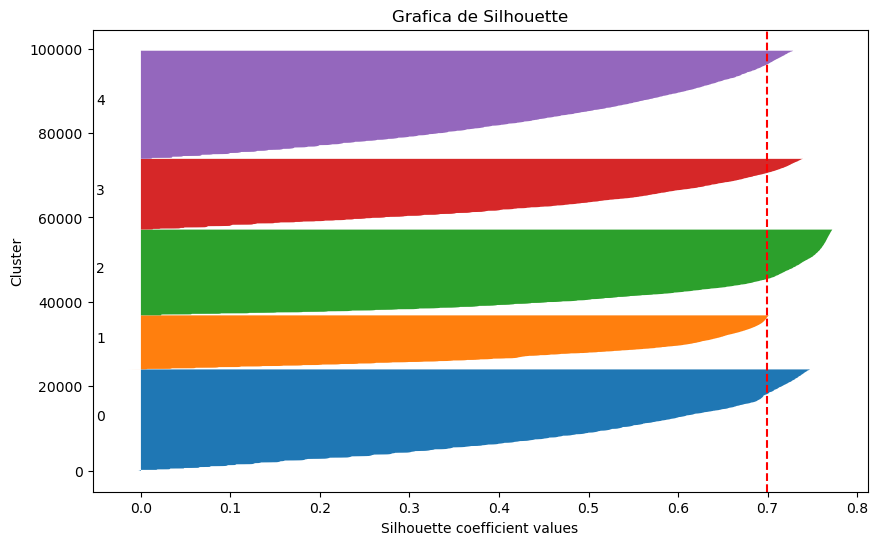

In [171]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples

# Graficamos Silhouette score.

pred_pd = predictions.select("features", "prediction").toPandas()
X = np.vstack(pred_pd["features"].values)
labels = pred_pd["prediction"].values

sample_values = silhouette_samples(X, labels)

plt.figure(figsize=(10, 6))
y_lower = 10
for i in np.unique(labels):
    ith_cluster_silhouette_values = sample_values[labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

plt.axvline(x=silhouette, color="red", linestyle="--")
plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster")
plt.title("Grafica de Silhouette")
plt.show()

In [173]:
# Juntar las previsiones de cluster con la tabla RFM final
clientes_clusterizados = rfm_final.join(predictions.select("customer_id", col("prediction").alias("cluster")), "customer_id", "inner")
print("Tabela final com RFM Scores e Cluster:")
clientes_clusterizados.show(10)

Tabela final com RFM Scores e Cluster:
+--------------------+--------+----------+---------+-------+-------+-------+---------+-------+
|         customer_id|Recencia|Frequencia|Monetario|R_Score|F_Score|M_Score|RFM_Score|cluster|
+--------------------+--------+----------+---------+-------+-------+-------+---------+-------+
|00050bf6e01e69d5c...|    2792|         1|    85.23|      2|      2|      2|      222|      3|
|000598caf2ef41174...|    2464|         1|  1255.71|      5|      2|      5|      525|      2|
|0013cd8e350a7cc76...|    2560|         1|     92.6|      4|      2|      3|      423|      4|
|0015bc9fd2d539544...|    2525|         1|   132.19|      5|      2|      4|      524|      2|
|0015f7887e2fde13d...|    2840|         1|   186.74|      1|      2|      4|      124|      3|
|001df1ee5c36767aa...|    2470|         1|    42.86|      5|      2|      1|      521|      2|
|001f150aebb5d897f...|    2558|         1|   125.97|      4|      2|      3|      423|      4|
|001f35d9f2

In [174]:
# Analisar las características de cada cluster
print("\nAnálise das características médias por cluster:")
clientes_clusterizados.groupBy("cluster") \
    .agg(avg("Recencia").alias("Recencia_Media"), \
         avg("Frequencia").alias("Frequencia_Media"), \
         avg("Monetario").alias("Monetario_Medio"), \
         countDistinct("customer_id").alias("Num_Clientes")) \
    .orderBy("cluster") \
    .show()


Análise das características médias por cluster:
+-------+------------------+----------------+------------------+------------+
|cluster|    Recencia_Media|Frequencia_Media|   Monetario_Medio|Num_Clientes|
+-------+------------------+----------------+------------------+------------+
|      0| 2706.040466763909|             1.0| 156.5970893936242|       23995|
|      1| 2958.230378361476|             1.0|166.05523610590166|       12792|
|      2|2493.3728145776904|             1.0|165.25295050480167|       20305|
|      3| 2824.855343283582|             1.0| 159.2049522388065|       16750|
|      4|2598.0594554474783|             1.0| 160.3642040704716|       25599|
+-------+------------------+----------------+------------------+------------+



Modelo para analisis de la clusterizacion.

In [175]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

#Usando solo las columnas que vamos analisar
Gboost_data = clientes_clusterizados["R_Score","F_Score","M_Score", "cluster"]

# Indexação da variável target
label_indexer = StringIndexer(inputCol="cluster", outputCol="indexedLabel")

# Vetorização das features
feature_assembler = VectorAssembler(
    inputCols=["R_Score", "F_Score", "M_Score"],
    outputCol="features"
)


In [176]:


# Modelo GBT - No funciona en este caso pues trabaja solo con binarios. ASi que cambiamos a un randon forest.
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="features", maxIter=10)

#Modelo Randon Forest
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features", numTrees=100)

# Pipeline
pipeline = Pipeline(stages=[label_indexer, feature_assembler, rf])

(train_data, test_data) = Gboost_data.randomSplit([0.7, 0.3], seed=42)
 
# Treinamento
model = pipeline.fit(train_data)

# Previsão
predictions = model.transform(test_data)

# Avaliação
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)

predictionAndLabels = predictions.select("prediction", "indexedLabel").rdd.map(tuple)
metrics = MulticlassMetrics(predictionAndLabels)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(metrics.confusionMatrix())



/usr/local/spark/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.76
Confusion Matrix:
DenseMatrix([[5635., 2102.,    0.,    0.,    0.],
             [   0., 7076.,    0.,    0.,    0.],
             [  68.,    0., 5959.,    0.,    0.],
             [   0., 2587.,    0.,    0., 2371.],
             [   0.,    0.,    0.,    0., 3776.]])


6. Modelo de Recomendaciones de Productos (ALS - Collaborative Filtering)

In [ ]:
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import expr

In [ ]:
# Certificar que os IDs são inteiros e não nulos
als_data = df_ordens.select(
    col("customer_id").cast(IntegerType()),
    col("product_id").cast(IntegerType()),
    col("product_qty").cast(FloatType()) # Usando cantidad como 'rating' implícito
).na.drop() # Quitar lineas donde customer_id o product_id son nulos mismo despues del cast

In [ ]:
# renombrar columnas para el patron de ALS
als_data = als_data.withColumnRenamed("customer_id", "userCol") \
                   .withColumnRenamed("product_id", "itemCol") \
                   .withColumnRenamed("product_qty", "ratingCol")

In [ ]:
# Dividir datos en train y test 
(training, test) = als_data.randomSplit([0.8, 0.2], seed=1234)

In [ ]:
# Construir modelo ALS con una configuracion basica
als_model = ALS(userCol="userCol", itemCol="itemCol", ratingCol="ratingCol",
          implicitPrefs=True, coldStartStrategy="drop",
          nonnegative=True)

In [ ]:
from pyspark.sql.functions import explode
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# test de los hiperparametros para ajuste.
paramGrid = ParamGridBuilder() \
    .addGrid(als_model.rank, [10, 20, 30]) \
    .addGrid(als_model.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(als_model.alpha, [0.5, 1.0, 2.0]) \
    .build()


#cross validator Evaluator

evaluator = RegressionEvaluator(metricName="rmse", labelCol="ratingCol", predictionCol="prediction")

cv = CrossValidator(estimator=als_model,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3)

# Entrenar el modelo
cv_model = cv.fit(training)

# Mejor modelo
mejor_modelo = cv_model.bestModel

# Previsiones en el conjunto de test
previsoes = mejor_modelo.transform(test)

# Cálculo de RMSE y MAE
rmse = evaluator.evaluate(previsoes.na.drop(subset=["prediction"]))
print(f"Melhor RMSE no teste: {rmse}")
evaluator_mae = RegressionEvaluator(metricName="mae", labelCol="ratingCol", predictionCol="prediction")
mae = evaluator_mae.evaluate(previsoes)
print(f"Mean Absolute Error (MAE):    {mae:.4f}")

# Generar las recomendaciones formatadas
recomendaciones = mejor_modelo.recommendForAllUsers(5)


Melhor RMSE no teste: 75.36105472747009
Mean Absolute Error (MAE):    14.4987


In [ ]:
print("Top 5 Recomendaciones por usuario (IDs de Produto):")
recomendaciones.show(10, truncate=False)

Top 5 Recomendaciones por usuario (IDs de Produto):
+-------+-------------------------------------------------------------------------------------------------------+
|userCol|recommendations                                                                                        |
+-------+-------------------------------------------------------------------------------------------------------+
|580    |[{5674, 0.8311895}, {2418, 0.7814818}, {14536, 0.75606006}, {19808, 0.74783796}, {17766, 0.7012954}]   |
|470    |[{19808, 0.93692124}, {20412, 0.88025147}, {12956, 0.7969291}, {14536, 0.6735073}, {2418, 0.66678643}] |
|430    |[{2678, 1.188983}, {13610, 1.1402546}, {13609, 1.1097128}, {10594, 1.1010408}, {16620, 1.1009189}]     |
|450    |[{12936, 0.6646481}, {21148, 0.44092023}, {20262, 0.43391424}, {2786, 0.4117555}, {14619, 0.39823347}] |
|80     |[{15167, 1.8881321}, {10945, 1.2174681}, {11630, 1.0428602}, {6685, 1.02357}, {14808, 0.9978072}]      |
|60     |[{2786, 1.3523881}, {12956,

In [ ]:
# Formatear las recomendaciones para mejor visualizarlas
user_recs_formatted = recomendaciones.withColumn("rec_exp", expr("explode(recommendations)")) \
                               .select("userCol", col("rec_exp.itemCol").alias("product_id"), col("rec_exp.rating").alias("predicted_rating"))
print("Recomendaciones formateadas (Usuário, Produto ID, Rating Predito):")
user_recs_formatted.show(20)

Recomendaciones formateadas (Usuário, Produto ID, Rating Predito):
+-------+----------+----------------+
|userCol|product_id|predicted_rating|
+-------+----------+----------------+
|    580|      5674|       0.8311895|
|    580|      2418|       0.7814818|
|    580|     14536|      0.75606006|
|    580|     19808|      0.74783796|
|    580|     17766|       0.7012954|
|    470|     19808|      0.93692124|
|    470|     20412|      0.88025147|
|    470|     12956|       0.7969291|
|    470|     14536|       0.6735073|
|    470|      2418|      0.66678643|
|    430|      2678|        1.188983|
|    430|     13610|       1.1402546|
|    430|     13609|       1.1097128|
|    430|     10594|       1.1010408|
|    430|     16620|       1.1009189|
|    450|     12936|       0.6646481|
|    450|     21148|      0.44092023|
|    450|     20262|      0.43391424|
|    450|      2786|       0.4117555|
|    450|     14619|      0.39823347|
+-------+----------+----------------+
only showing top 20 r

In [ ]:
# Juntar con nombres de productos para que sean mas legíveis
# Seleccionar apenas id e nombre del producto para el join
df_produtos_nomes = df_produtos.select(col("product_id").cast(IntegerType()), "post_title")

user_recs_final = user_recs_formatted.join(df_produtos_nomes, user_recs_formatted.product_id == df_produtos_nomes.product_id, "left") \
                                  .select(
    col("userCol"),
    df_produtos_nomes.product_id.alias("product_id"),
    col("post_title"),
    col("predicted_rating")
)

In [ ]:
# Agruparlos para ver los top 5 por usuário de forma mais clara
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, collect_list
from pyspark.sql.functions import struct

window_spec = Window.partitionBy("userCol").orderBy(col("predicted_rating").desc())

user_recs_grouped = user_recs_final \
    .withColumn("rank", rank().over(window_spec)) \
    .where(col("rank") <= 5) \
    .groupBy("userCol") \
    .agg(collect_list(struct("product_id", "post_title", "predicted_rating")).alias("top_5_recomendaciones"))
    
user_recs_grouped.show(10, truncate=False)

+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userCol|top_5_recomendacoes                                                                                                                                                                                                                                                                                   |
+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|26     |[{614, HP 15-EF2747WM, 1.3718138}, {14215, ASROCK A520M PRO4, 1.3688942}, {1

#### CHURN

NO ESTÁ BIEN.

7. Modelo de Previsão de Churn

In [ ]:
from pyspark.sql.functions import datediff, current_date, lit, avg as spark_avg, count as spark_count, max as spark_max, struct
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

In [ ]:
# 7.1 Definição de Churn e Criação de Labels
# Definir churn: Cliente que não fez compra nos últimos X dias (ex: 90 dias)
# Este valor pode ser ajustado com base no conhecimento do negócio
churn_threshold_days = 90

In [ ]:
# Usar a tabela RFM que já tem a Recência (dias desde a última compra)
# Se Recencia > churn_threshold_days, então churn = 1, senão 0
# Certificar que rfm_final está disponível
if 'rfm_final' not in locals():
    print("Erro: Tabela rfm_final não encontrada. Execute a etapa RFM primeiro.")
    # Adicionar código para recarregar ou recalcular rfm_final se necessário
    # Por exemplo:
    # rfm_r = df_ordens.groupBy("customer_id").agg(spark_min("recencia_ordem_dias").alias("Recencia"))
    # rfm_f = df_ordens.groupBy("customer_id").agg(countDistinct("order_id").alias("Frequencia"))
    # rfm_m = df_ordens.groupBy("customer_id").agg(spark_sum("product_gross_revenue").alias("Monetario"))
    # rfm_final = rfm_r.join(rfm_f, "customer_id", "inner").join(rfm_m, "customer_id", "inner")

In [ ]:
churn_labels = rfm_final.withColumn("churn_label",
                                    when(col("Recencia") > churn_threshold_days, 1).otherwise(0))

In [ ]:
print(f"Definindo churn como inatividade > {churn_threshold_days} dias.")
churn_labels.groupBy("churn_label").count().show()

Definindo churn como inatividade > 90 dias.
+-----------+-----+
|churn_label|count|
+-----------+-----+
|          1|   80|
+-----------+-----+



In [ ]:
# 7.2 Feature Engineering Adicional
# Juntar com df_clientes para obter 'dias_desde_registro'
# Certificar que df_clientes está disponível e processado
if 'df_clientes' not in locals() or 'dias_desde_registro' not in df_clientes.columns:
     print("Erro: df_clientes ou coluna 'dias_desde_registro' não encontrada.")
     # Recarregar/reprocessar df_clientes se necessário
     # df_clientes = spark.read.csv(path_clientes, header=True, inferSchema=True, sep=',')
     # df_clientes = df_clientes.dropDuplicates(['user_id'])
     # df_clientes = df_clientes.withColumn("user_registered_ts", to_timestamp(col("user_registered"), "yyyy-MM-dd HH:mm:ss"))
     # df_clientes = df_clientes.withColumn("dias_desde_registro", datediff(current_date(), col("user_registered_ts")))

In [ ]:
churn_data = churn_labels.join(df_clientes.select(col("user_id").alias("customer_id_ref"), "dias_desde_registro"),
                               churn_labels.customer_id == col("customer_id_ref"), "left") \
                         .select("customer_id", "Recencia", "Frequencia", "Monetario", "dias_desde_registro", "churn_label") \
                         .na.fill(0, subset=["dias_desde_registro"]) # Preencher nulos em dias_desde_registro (ex: se cliente não encontrado)

In [ ]:
print("Dados preparados para modelo de churn:")
churn_data.show(5)

Dados preparados para modelo de churn:
+-----------+--------+----------+-----------------+-------------------+-----------+
|customer_id|Recencia|Frequencia|        Monetario|dias_desde_registro|churn_label|
+-----------+--------+----------+-----------------+-------------------+-----------+
|        737|     134|         2|          4715.28|                  0|          1|
|        516|     154|         1|           1044.3|                  0|          1|
|        580|     197|         2|           1770.0|                  0|          1|
|        513|     198|        13|50761.23999999999|                  0|          1|
|        613|     210|         1|           1534.0|                  0|          1|
+-----------+--------+----------+-----------------+-------------------+-----------+
only showing top 5 rows



In [ ]:
# 7.3 Preparação para Modelagem (VectorAssembler, Scaler, Split)
# Colunas de features
feature_cols = ["Recencia", "Frequencia", "Monetario", "dias_desde_registro"]

In [ ]:
# Montar vetor de features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw", handleInvalid="skip") # Skip rows with nulls

In [ ]:
# Escalar features numéricas (importante para regressão logística)
scaler_churn = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=True)

In [ ]:
# Criar pipeline para pré-processamento
preprocess_pipeline = Pipeline(stages=[assembler, scaler_churn])
preprocess_model = preprocess_pipeline.fit(churn_data)
final_churn_data = preprocess_model.transform(churn_data)

In [ ]:
# Selecionar colunas finais e renomear label
final_churn_data = final_churn_data.select(col("customer_id"), col("features"), col("churn_label").alias("label"))

In [ ]:
print("Dados finais com features escaladas e label:")
final_churn_data.show(5, truncate=False)

Dados finais com features escaladas e label:
+-----------+------------------------------------------------------------------------------------+-----+
|customer_id|features                                                                            |label|
+-----------+------------------------------------------------------------------------------------+-----+
|737        |[-1.2204026035000965,-0.33474376723009847,-0.34684949808465804,-0.6423398862187408] |1    |
|516        |[-0.9020713081626082,-0.3828218666527338,-0.40099505711315014,-0.6423398862187408]  |1    |
|580        |[-0.21765902318700828,-0.33474376723009847,-0.39029125807665943,-0.6423398862187408]|1    |
|513        |[-0.20174245842013386,0.1941153264188905,0.3323109019184983,-0.6423398862187408]    |1    |
|613        |[-0.010743681217640863,-0.3828218666527338,-0.39377216833242873,-0.6423398862187408]|1    |
+-----------+------------------------------------------------------------------------------------+-----+
only showi

In [ ]:
# Verificar se há dados suficientes após pré-processamento
if final_churn_data.count() == 0:
    print("Erro: Nenhum dado restante após pré-processamento para o modelo de churn.")
else:
    # Dividir em treino e teste
    (train_data, test_data) = final_churn_data.randomSplit([0.8, 0.2], seed=42)
    print(f"Registros de treino: {train_data.count()}, Registros de teste: {test_data.count()}")

    # 7.4 Treinamento do Modelo (Ex: Regressão Logística)
    if train_data.count() > 0:
        lr = LogisticRegression(featuresCol="features", labelCol="label")
        lr_model = lr.fit(train_data)
        print("Modelo de Regressão Logística treinado.")

        # 7.5 Avaliação do Modelo
        if test_data.count() > 0:
            predictions_lr = lr_model.transform(test_data)
            print("Predições no conjunto de teste:")
            predictions_lr.select("customer_id", "label", "probability", "prediction").show(10, truncate=False)

            # Avaliar usando AUC
            evaluator_auc = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
            # Lidar com possíveis NaNs na coluna de predição se houver
            auc = evaluator_auc.evaluate(predictions_lr.na.drop(subset=["rawPrediction"]))
            print(f"Área sob a curva ROC (AUC) no conjunto de teste: {auc}")

            # Avaliar usando outras métricas (Accuracy, Precision, Recall, F1)
            evaluator_multi = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
            accuracy = evaluator_multi.evaluate(predictions_lr, {evaluator_multi.metricName: "accuracy"})
            precision = evaluator_multi.evaluate(predictions_lr, {evaluator_multi.metricName: "weightedPrecision"})
            recall = evaluator_multi.evaluate(predictions_lr, {evaluator_multi.metricName: "weightedRecall"})
            f1 = evaluator_multi.evaluate(predictions_lr, {evaluator_multi.metricName: "f1"})

            print(f"Accuracy: {accuracy}")
            print(f"Precision: {precision}")
            print(f"Recall: {recall}")
            print(f"F1 Score: {f1}")
        else:
            print("Não há dados de teste suficientes para avaliação.")
    else:
        print("Não há dados de treino suficientes para treinar o modelo.")

Registros de treino: 63, Registros de teste: 17
Modelo de Regressão Logística treinado.
Predições no conjunto de teste:
+-----------+-----+-----------+----------+
|customer_id|label|probability|prediction|
+-----------+-----+-----------+----------+
|30         |1    |[0.0,1.0]  |1.0       |
|72         |1    |[0.0,1.0]  |1.0       |
|80         |1    |[0.0,1.0]  |1.0       |
|172        |1    |[0.0,1.0]  |1.0       |
|244        |1    |[0.0,1.0]  |1.0       |
|260        |1    |[0.0,1.0]  |1.0       |
|279        |1    |[0.0,1.0]  |1.0       |
|327        |1    |[0.0,1.0]  |1.0       |
|432        |1    |[0.0,1.0]  |1.0       |
|435        |1    |[0.0,1.0]  |1.0       |
+-----------+-----+-----------+----------+
only showing top 10 rows

Área sob a curva ROC (AUC) no conjunto de teste: 1.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [ ]:
# 1. Avaliador AUC e AUC-PR
evaluator_auc = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
evaluator_pr = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderPR")

# Lidar com possíveis NaNs na coluna de predição se houver (ex: coldStartStrategy)
valid_predictions = predictions_lr.na.drop(subset=["rawPrediction", "prediction", "label"])

if valid_predictions.count() == 0:
    print("Não há predições válidas para avaliação após remover NaNs.")
else: 
    print("Há predições válidas para avaliação após remover NaNs.")

Há predições válidas para avaliação após remover NaNs.


In [ ]:
auc_score = evaluator_auc.evaluate(valid_predictions)
pr_auc_score = evaluator_pr.evaluate(valid_predictions)
print(f"Área sob a Curva ROC (AUC): {auc_score:.4f}")
print(f"Área sob a Curva Precision-Recall (AUC-PR): {pr_auc_score:.4f}")



Área sob a Curva ROC (AUC): 1.0000
Área sob a Curva Precision-Recall (AUC-PR): 1.0000


In [ ]:
# 2. Avaliador Multiclasse para Accuracy, Precision, Recall, F1
evaluator_multi = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

accuracy = evaluator_multi.evaluate(valid_predictions, {evaluator_multi.metricName: "accuracy"})
precision_w = evaluator_multi.evaluate(valid_predictions, {evaluator_multi.metricName: "weightedPrecision"})
recall_w = evaluator_multi.evaluate(valid_predictions, {evaluator_multi.metricName: "weightedRecall"})
f1_w = evaluator_multi.evaluate(valid_predictions, {evaluator_multi.metricName: "f1"})

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision Ponderada: {precision_w:.4f}")
print(f"Recall Ponderado: {recall_w:.4f}")
print(f"F1-Score Ponderado: {f1_w:.4f}")




Accuracy: 1.0000
Precision Ponderada: 1.0000
Recall Ponderado: 1.0000
F1-Score Ponderado: 1.0000


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Verifique as labels presentes
present_labels = valid_predictions.select("label").distinct().rdd.flatMap(lambda x: x).collect()

evaluator_multi = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

for label in present_labels:
    precision = evaluator_multi.evaluate(valid_predictions, {
        evaluator_multi.metricName: "precisionByLabel",
        evaluator_multi.metricLabel: label
    })
    recall = evaluator_multi.evaluate(valid_predictions, {
        evaluator_multi.metricName: "recallByLabel",
        evaluator_multi.metricLabel: label
    })
    f1 = evaluator_multi.evaluate(valid_predictions, {
        evaluator_multi.metricName: "f1",
        evaluator_multi.metricLabel: label
    })

    print(f"Label {label}: Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}")

# 3. Métricas por Classe
print("\n-- Métricas por Classe --")
labels = [0.0, 1.0]
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# 🔍 Verifique quais classes realmente estão presentes
labels_presentes = valid_predictions.select("label").distinct().rdd.flatMap(lambda x: x).collect()

print("\n-- Métricas por Classe (presentes nos dados) --")
for label in sorted(labels_presentes):
    evaluator.setMetricLabel(label)

    evaluator.setMetricName("precisionByLabel")
    precision = evaluator.evaluate(valid_predictions)

    evaluator.setMetricName("recallByLabel")
    recall = evaluator.evaluate(valid_predictions)

    evaluator.setMetricName("f1")
    f1 = evaluator.evaluate(valid_predictions)

    print(f"Label {label}: Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}")

    


Label 1: Precision = 1.0000, Recall = 1.0000, F1 = 1.0000

-- Métricas por Classe --

-- Métricas por Classe (presentes nos dados) --
Label 1: Precision = 1.0000, Recall = 1.0000, F1 = 1.0000


In [ ]:
# 4. Matriz de Confusão (Cálculo com PySpark)
print("\n-- Matriz de Confusão --")
# Calcula TP, TN, FP, FN diretamente
tp = valid_predictions.filter("label = 1.0 AND prediction = 1.0").count()
tn = valid_predictions.filter("label = 0.0 AND prediction = 0.0").count()
fp = valid_predictions.filter("label = 0.0 AND prediction = 1.0").count()
fn = valid_predictions.filter("label = 1.0 AND prediction = 0.0").count()

print(f"                 Predito 0 | Predito 1")
print(f"Real 0 (Não Churn):  {tn:^8} | {fp:^8}")
print(f"Real 1 (Churn):      {fn:^8} | {tp:^8}")


-- Matriz de Confusão --
                 Predito 0 | Predito 1
Real 0 (Não Churn):     0     |    0    
Real 1 (Churn):         0     |    17   


Próximo passo: Finalizar e entregar o notebook

In [ ]:
# Finalizar SparkSession
spark.stop()
print("SparkSession finalizada.")